In [1]:
import numpy as np
import time


class Node(object):
    '''结点对象'''
    def __init__(self, item=None, label=None, dim=None, parent=None, left_child=None, right_child=None):
        self.item = item   # 结点的值(样本信息)
        self.label = label  # 结点的标签
        self.dim = dim   # 结点的切分的维度(特征)
        self.parent = parent  # 父结点
        self.left_child = left_child  # 左子树
        self.right_child = right_child # 右子树


class KDTree(object):
    '''kd树'''

    def __init__(self, aList, labelList):
        self.__length = 0  # 不可修改
        self.__root = self.__create(aList,labelList)  # 根结点, 私有属性, 不可修改

    def __create(self, aList, labelList, parentNode=None):
        '''
        创建kd树
        :param aList: 需要传入一个类数组对象(行数表示样本数，列数表示特征数)
        :labellist: 样本的标签
        :parentNode: 父结点
        :return: 根结点
        '''
        dataArray = np.array(aList)
        m,n = dataArray.shape
        labelArray = np.array(labelList).reshape(m,1)
        if m == 0:  # 样本集为空
            return None
        # 求所有特征的方差，选择最大的那个特征作为切分超平面
        var_list = [np.var(dataArray[:,col]) for col in range(n)]  # 获取每一个特征的方差
        max_index = var_list.index(max(var_list))  # 获取最大方差特征的索引
        # 样本按最大方差特征进行升序排序后，取出位于中间的样本
        max_feat_ind_list = dataArray[:,max_index].argsort()
        mid_item_index = max_feat_ind_list[m // 2]
        if m == 1:  # 样本为1时，返回自身
            self.__length += 1
            return Node(dim=max_index,label=labelArray[mid_item_index], item=dataArray[mid_item_index], parent=parentNode, left_child=None, right_child=None)

        # 生成结点
        node = Node(dim=max_index, label=labelArray[mid_item_index], item=dataArray[mid_item_index], parent=parentNode, )
        # 构建有序的子树
        left_tree = dataArray[max_feat_ind_list[:m // 2]] # 左子树
        left_label = labelArray[max_feat_ind_list[:m // 2]] # 左子树标签
        left_child = self.__create(left_tree,left_label,node)
        if m == 2:  # 只有左子树，无右子树
            right_child = None
        else:
            right_tree = dataArray[max_feat_ind_list[m // 2 + 1:]] # 右子树
            right_label = labelArray[max_feat_ind_list[m // 2 + 1:]] # 右子树标签
            right_child = self.__create(right_tree,right_label,node)
            # self.__length += 1
        # 左右子树递归调用自己，返回子树根结点
        node.left_child=left_child
        node.right_child=right_child
        self.__length += 1
        return node

    @property
    def length(self):
        return self.__length

    @property
    def root(self):
        return self.__root

    def transfer_dict(self,node):
        '''
        查看kd树结构
        :node:需要传入根结点对象
        :return: 字典嵌套格式的kd树,字典的key是self.item,其余项作为key的值，类似下面格式
        {(1,2,3):{
                'label':1,
                'dim':0,
                'left_child':{(2,3,4):{
                                     'label':1,
                                     'dim':1,
                                     'left_child':None,
                                     'right_child':None
                                    },
                'right_child':{(4,5,6):{
                                        'label':1,
                                        'dim':1,
                                        'left_child':None,
                                        'right_child':None
                                        }
                }
        '''
        if node == None:
            return None
        kd_dict = {}
        kd_dict[tuple(node.item)] = {}  # 将自身值作为key
        kd_dict[tuple(node.item)]['label'] = node.label[0]
        kd_dict[tuple(node.item)]['dim'] = node.dim
        kd_dict[tuple(node.item)]['parent'] = tuple(node.parent.item) if node.parent else None
        kd_dict[tuple(node.item)]['left_child'] = self.transfer_dict(node.left_child)
        kd_dict[tuple(node.item)]['right_child'] = self.transfer_dict(node.right_child)
        return kd_dict

    def transfer_list(self,node, kdList=[]):
        '''
        将kd树转化为列表嵌套字典的嵌套字典的列表输出
        :param node: 需要传入根结点
        :return: 返回嵌套字典的列表
        '''
        if node == None:
            return None
        element_dict = {}
        element_dict['item'] = tuple(node.item)
        element_dict['label'] = node.label[0]
        element_dict['dim'] = node.dim
        element_dict['parent'] = tuple(node.parent.item) if node.parent else None
        element_dict['left_child'] = tuple(node.left_child.item) if node.left_child else None
        element_dict['right_child'] = tuple(node.right_child.item) if node.right_child else None
        kdList.append(element_dict)
        self.transfer_list(node.left_child, kdList)
        self.transfer_list(node.right_child, kdList)
        return kdList

    def _find_nearest_neighbour(self, item):
        '''
        找最近邻点
        :param item:需要预测的新样本
        :return: 距离最近的样本点
        '''
        itemArray = np.array(item)
        if self.length == 0:  # 空kd树
            return None
        # 递归找离测试点最近的那个叶结点
        node = self.__root
        if self.length == 1: # 只有一个样本
            return node
        while True:
            cur_dim = node.dim
            if item[cur_dim] == node.item[cur_dim]:
                return node
            elif item[cur_dim] < node.item[cur_dim]:  # 进入左子树
                if node.left_child == None:  # 左子树为空，返回自身
                    return node
                node = node.left_child
            else:
                if node.right_child == None:  # 右子树为空，返回自身
                    return node
                node = node.right_child

    def knn_algo(self, item, k=1):
        '''
        找到距离测试样本最近的前k个样本
        :param item: 测试样本
        :param k: knn算法参数，定义需要参考的最近点数量，一般为1-5
        :return: 返回前k个样本的最大分类标签
        '''
        if self.length <= k:
            label_dict = {}
            # 获取所有label的数量
            for element in self.transfer_list(self.root):
                if element['label'] in label_dict:
                    label_dict[element['label']] += 1
                else:
                    label_dict[element['label']] = 1
            sorted_label = sorted(label_dict.items(), key=lambda item:item[1],reverse=True)  # 给标签排序
            return sorted_label[0][0]

        item = np.array(item)
        node = self._find_nearest_neighbour(item)  # 找到最近的那个结点
        if node == None:  # 空树
            return None
        #print('搜索靠近点%s的100个细胞'%(item))
        node_list = []
        distance = np.sqrt(sum((item-node.item)**2))  # 测试点与最近点之间的距离
        least_dis = distance
        # 返回上一个父结点，判断以测试点为圆心，distance为半径的圆是否与父结点分隔超平面相交，若相交，则说明父结点的另一个子树可能存在更近的点
        node_list.append([distance, tuple(node.item), node.label[0]])  # 需要将距离与结点一起保存起来

        # 若最近的结点不是叶结点，则说明，它还有左子树
        if node.left_child != None:
            left_child = node.left_child
            left_dis = np.sqrt(sum((item-left_child.item)**2))
            if k > len(node_list) or least_dis < least_dis:
                node_list.append([left_dis, tuple(left_child.item), left_child.label[0]])
                node_list.sort()  # 对结点列表按距离排序
                least_dis = node_list[-1][0] if k >= len(node_list) else node_list[k-1][0]
        # 回到父结点
        while True:
            if node == self.root:  # 已经回到kd树的根结点
                break
            parent = node.parent
            # 计算测试点与父结点的距离，与上面距离做比较
            par_dis = np.sqrt(sum((item-parent.item)**2))
            if k >len(node_list) or par_dis < least_dis:  # k大于结点数或者父结点距离小于结点列表中最大的距离
                node_list.append([par_dis, tuple(parent.item) , parent.label[0]])
                node_list.sort()  # 对结点列表按距离排序
                least_dis = node_list[-1][0] if k >= len(node_list) else node_list[k - 1][0]

            # 判断父结点的另一个子树与结点列表中最大的距离构成的圆是否有交集
            if k >len(node_list) or abs(item[parent.dim] - parent.item[parent.dim]) < least_dis :  # 说明父结点的另一个子树与圆有交集
                # 说明父结点的另一子树区域与圆有交集
                other_child = parent.left_child if parent.left_child != node else parent.right_child  # 找另一个子树
                # 测试点在该子结点超平面的左侧
                if other_child != None:
                    if item[parent.dim] - parent.item[parent.dim] <= 0:
                        self.left_search(item,other_child,node_list,k)
                    else:
                        self.right_search(item,other_child,node_list,k)  # 测试点在该子结点平面的右侧

            node = parent  # 否则继续返回上一层
        # 接下来取出前k个元素中最大的分类标签
        label_dict = {}
        node_list = node_list[:k]
        # 获取所有label的数量
        for element in node_list:
            if element[2] in label_dict:
                label_dict[element[2]] += 1
            else:
                label_dict[element[2]] = 1
        sorted_label = sorted(label_dict.items(), key=lambda item:item[1], reverse=True)  # 给标签排序
        return sorted_label[0][0],node_list

    def left_search(self, item, node, nodeList, k):
        '''
        按左中右顺序遍历子树结点，返回结点列表
        :param node: 子树结点
        :param item: 传入的测试样本
        :param nodeList: 结点列表
        :param k: 搜索比较的结点数量
        :return: 结点列表
        '''
        nodeList.sort()  # 对结点列表按距离排序
        least_dis = nodeList[-1][0] if k >= len(nodeList) else nodeList[k - 1][0]
        if node.left_child == None and node.right_child == None:  # 叶结点
            dis = np.sqrt(sum((item - node.item) ** 2))
            if k > len(nodeList) or dis < least_dis:
                nodeList.append([dis, tuple(node.item), node.label[0]])
            return
        self.left_search(item, node.left_child, nodeList, k)
        # 每次进行比较前都更新nodelist数据
        nodeList.sort()  # 对结点列表按距离排序
        least_dis = nodeList[-1][0] if k >= len(nodeList) else nodeList[k - 1][0]
        # 比较根结点
        dis = np.sqrt(sum((item-node.item)**2))
        if k > len(nodeList) or dis < least_dis:
            nodeList.append([dis, tuple(node.item), node.label[0]])
        # 右子树
        if k > len(nodeList) or abs(item[node.dim] - node.item[node.dim]) < least_dis: # 需要搜索右子树
            if node.right_child != None:
                self.left_search(item, node.right_child, nodeList, k)

        return nodeList

    def right_search(self,item, node, nodeList, k):
        '''
        按右根左顺序遍历子树结点
        :param item: 测试的样本点
        :param node: 子树结点
        :param nodeList: 结点列表
        :param k: 搜索比较的结点数量
        :return: 结点列表
        '''
        nodeList.sort()  # 对结点列表按距离排序
        least_dis = nodeList[-1][0] if k >= len(nodeList) else nodeList[k - 1][0]
        if node.left_child == None and node.right_child == None:  # 叶结点
            dis = np.sqrt(sum((item - node.item) ** 2))
            if k > len(nodeList) or dis < least_dis:
                nodeList.append([dis, tuple(node.item), node.label[0]])
            return
        if node.right_child != None:
            self.right_search(item, node.right_child, nodeList, k)

        nodeList.sort()  # 对结点列表按距离排序
        least_dis = nodeList[-1][0] if k >= len(nodeList) else nodeList[k - 1][0]
        # 比较根结点
        dis = np.sqrt(sum((item - node.item) ** 2))
        if k > len(nodeList) or dis < least_dis:
            nodeList.append([dis, tuple(node.item), node.label[0]])
        # 左子树
        if k > len(nodeList) or abs(item[node.dim] - node.item[node.dim]) < least_dis: # 需要搜索左子树
            self.right_search(item, node.left_child, nodeList, k)

        return nodeList



In [2]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)


#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

from matplotlib.colors import LinearSegmentedColormap
sc_color=['#7CBB5F','#368650','#A499CC','#5E4D9A','#78C2ED','#866017', '#9F987F','#E0DFED',
 '#EF7B77', '#279AD7','#F0EEF0', '#1F577B', '#A56BA7', '#E0A7C8', '#E069A6', '#941456', '#FCBC10',
 '#EAEFC5', '#01A0A7', '#75C8CC', '#F0D7BC', '#D5B26C', '#D5DA48', '#B6B812', '#9DC3C3', '#A89C92', '#FEE00C', '#FEF2A1']
sc_color_cmap = LinearSegmentedColormap.from_list('Custom', sc_color, len(sc_color))

anndata(Ver):  0.8.0
scanpy(Ver):  1.9.1
matplotlib(Ver):  3.5.1
seaborn(Ver):  0.11.2
numpy(Ver):  1.22.3
pandas(Ver):  1.4.1
scvelo(Ver):  0.2.4
Pyomic(Ver):  1.1.4


In [3]:
rna=sc.read('data/rna_anno_new.h5ad')
rna=rna.raw.to_adata()
atac=sc.read('data/atac_anno_new.h5ad')
rna,atac

(AnnData object with n_obs × n_vars = 20037 × 37478
     obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'SRR', 'Cancer', 'Tissue', 'Developmental_Stage', 'sample', 'Type', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'SRR1', 'balancing_weight', 'n_counts', 'major_celltype', 'major_celltype_new'
     var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'hgnc_id', 'havana_gene', 'tag', 'dell'
     uns: 'Cancer_colors', 'Developmental_Stage_colors', 'SRR1_colors', 'Type_color

In [4]:
rna_loc=pd.DataFrame(rna.obsm['X_glue'], index=rna.obs.index)
atac_loc=pd.DataFrame(atac.obsm['X_glue'], index=atac.obs.index)

In [6]:
res_pair=pd.read_csv('res_pair_glue.csv')

In [7]:
def adata_rename(adata,pair,omic_name='omic_1'):
    adata=adata[pair[omic_name].values]
    adata.obs.index=pair.index
    return adata

In [8]:
rna=adata_rename(rna,res_pair,omic_name='omic_1')
atac=adata_rename(atac,res_pair,omic_name='omic_2')

In [9]:
rna,atac

(View of AnnData object with n_obs × n_vars = 12361 × 37478
     obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'SRR', 'Cancer', 'Tissue', 'Developmental_Stage', 'sample', 'Type', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'SRR1', 'balancing_weight', 'n_counts', 'major_celltype', 'major_celltype_new'
     var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'hgnc_id', 'havana_gene', 'tag', 'dell'
     uns: 'Cancer_colors', 'Developmental_Stage_colors', 'SRR1_colors', 'Ty

In [222]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Photoreceptor cells',
     '1': 'Photoreceptor cells',
     '2': 'Müller glia cells',#Germ-cell(Oid)
     '3': 'Photoreceptor cells',#Germ-cell(Oid)
     '4': 'STER cells',
     '5': 'Astrocytes',
     '6': 'Retinal stem cells',
     '7': 'Photoreceptor progenitor cell',
     '8': 'STER cells',
     '9': 'Photoreceptor cells',
     '10': 'Astrocytes',#Germ-cell(Oid)
     '11': 'Photoreceptor progenitor cell',
     '12': 'Müller glia cells',
     '13': 'Müller glia cells',
     '14': 'Müller glia cells',
     '15': 'STER cells',#Germ
     '16': 'Photoreceptor cells',#plasma
     '17': 'Lymphocytes',#plasma
     '18': 'Müller glia cells',
     '19': 'Müller glia cells',
     '20': 'Retinal pigment epithelium (RPE) cells',#Germ-cell(Oid)
     '21': 'STER cells',
     '22': 'Müller glia cells',
     '23': 'Müller glia cells',



}
rna.obs['major_celltype'] = rna.obs['leiden'].map(cluster2annotation).astype('category')

In [223]:
#这里纯人眼识别，其实可以开发一个算法的
cluster2annotation = {
     '0': 'Photoreceptor cells',
     '1': 'Photoreceptor cells',
     '2': 'Photoreceptor progenitor cell',#Germ-cell(Oid)
     '3': 'Retinal stem cells',#Germ-cell(Oid)
     '4': 'Astrocytes',
     '5': 'STER cells',
     '6': 'STER cells',
     '7': 'Müller glia cells',
     '8': 'Photoreceptor cells',
     '9': 'STER cells',
     '10': 'Photoreceptor progenitor cell',#Germ-cell(Oid)
     '11': 'Müller glia cells',
     '12': 'Retinal stem cells',
     '13': 'Müller glia cells',
     '14': 'Müller glia cells',
     '15': 'Astrocytes',#Germ
     '16': 'Lymphocytes',#plasma
     '17': 'Photoreceptor progenitor cell',#plasma
     '18': 'Müller glia cells',
     '19': 'Müller glia cells',
     '20': 'Retinal pigment epithelium (RPE) cells',#Germ-cell(Oid)



}
atac.obs['major_celltype'] = atac.obs['leiden'].map(cluster2annotation).astype('category')

In [224]:
rna.obs['major_celltype_new']=rna.obs['major_celltype']
rna.obs['major_celltype_new']=rna.obs['major_celltype_new'].astype('str')
rna.obs.loc[rna.obs['major_celltype']=='Retinal pigment epithelium (RPE) cells','major_celltype_new']='RPE cells'
rna.obs.loc[rna.obs['major_celltype']=='Retinal progenitor cells (RPCs)','major_celltype_new']='RPCs'
rna.obs.loc[rna.obs['major_celltype']=='Photoreceptor progenitor cell','major_celltype_new']='P-Photoreceptor cells'
rna.obs['major_celltype_new']=rna.obs['major_celltype_new'].astype('category')

In [225]:
atac.obs['major_celltype_new']=atac.obs['major_celltype']
atac.obs['major_celltype_new']=atac.obs['major_celltype_new'].astype('str')
atac.obs.loc[atac.obs['major_celltype']=='Retinal pigment epithelium (RPE) cells','major_celltype_new']='RPE cells'
atac.obs.loc[atac.obs['major_celltype']=='Retinal progenitor cells (RPCs)','major_celltype_new']='RPCs'
atac.obs.loc[atac.obs['major_celltype']=='Photoreceptor progenitor cell','major_celltype_new']='P-Photoreceptor cells'
atac.obs['major_celltype_new']=atac.obs['major_celltype_new'].astype('category')

<AxesSubplot:title={'center':'scATAC-seq'}, xlabel='X_umap1', ylabel='X_umap2'>

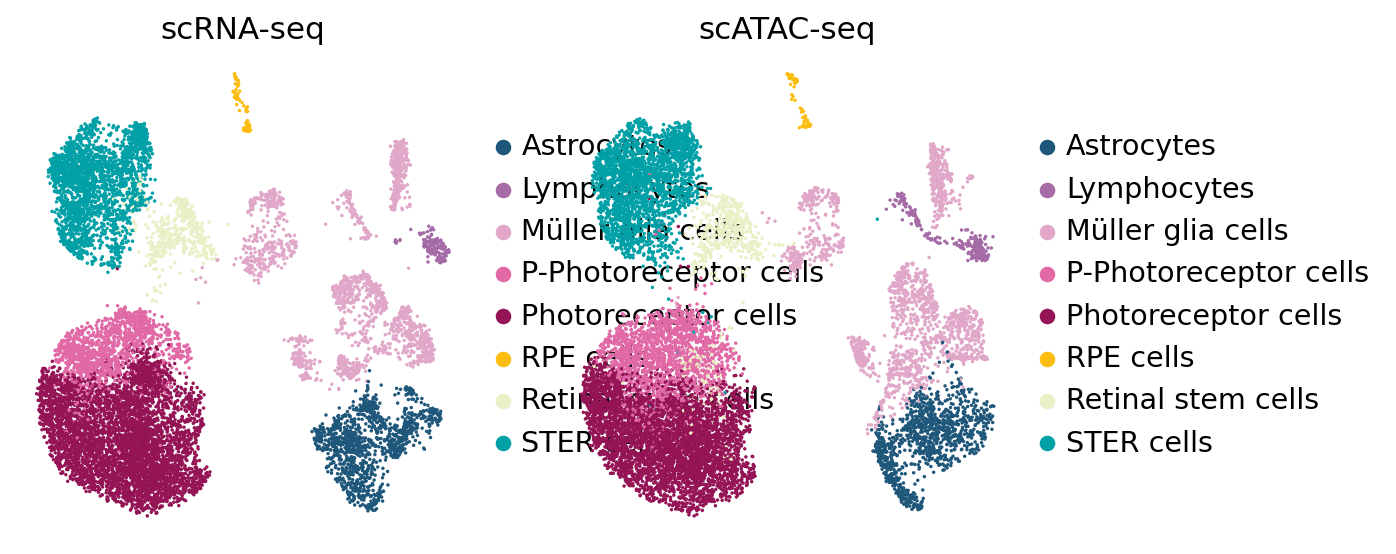

In [29]:
fig, axes = plt.subplots(1,2,figsize=(8,4))

sc.pl.embedding(
    rna,
    basis="X_umap",
    color=['major_celltype_new'],
    title='scRNA-seq',
    frameon=False,
    ncols=1,
    #save='_figure1_celltype.png',
    #return_fig=True,
    #wspace=0.5,
    show=False,
    ax=axes[0],
    palette=sc_color[11:],
)

sc.pl.embedding(
    atac,
    basis="X_umap",
    color=['major_celltype_new'],
    title='scATAC-seq',
    frameon=False,
    ncols=1,
    #save='_figure1_celltype.png',
    #return_fig=True,
    #wspace=0.5,
    show=False,
    ax=axes[1],
    palette=sc_color[11:],
)


In [30]:
cell_new_obs=rna.obs.index.tolist()

In [31]:
black_atac=anndata.AnnData(atac[cell_new_obs].X,obs=rna[cell_new_obs].obs,var=atac[cell_new_obs].var)
black_atac.obs.index=cell_new_obs
black_atac.obsm['X_glue']=atac[cell_new_obs].obsm['X_glue']
black_atac.obsm['X_umap']=atac[cell_new_obs].obsm['X_umap']
black_atac.uns['major_celltype_colors']=rna[cell_new_obs].uns['major_celltype_colors']
black_atac.uns['major_celltype_new_colors']=rna[cell_new_obs].uns['major_celltype_new_colors']
black_atac

AnnData object with n_obs × n_vars = 12361 × 296334
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'SRR', 'Cancer', 'Tissue', 'Developmental_Stage', 'sample', 'Type', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'SRR1', 'balancing_weight', 'n_counts', 'major_celltype', 'major_celltype_new'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score', 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
    uns: 'major_celltype_colors', 'major_celltype_new_colors'
    obsm: 'X_glue', 'X_umap'

In [32]:
black_atac.obs.index=black_atac.obs.index.astype('category')

In [33]:
new_cell_type=[]
for i in black_atac.obs['major_celltype_new']:
    if i=='Macrophage':
        new_cell_type.append('Macrophage/NEUT')
    else:
        new_cell_type.append(i)
black_atac.obs['major_celltype_new']=new_cell_type
black_atac.obs['major_celltype_new']=black_atac.obs['major_celltype_new'].astype('category')

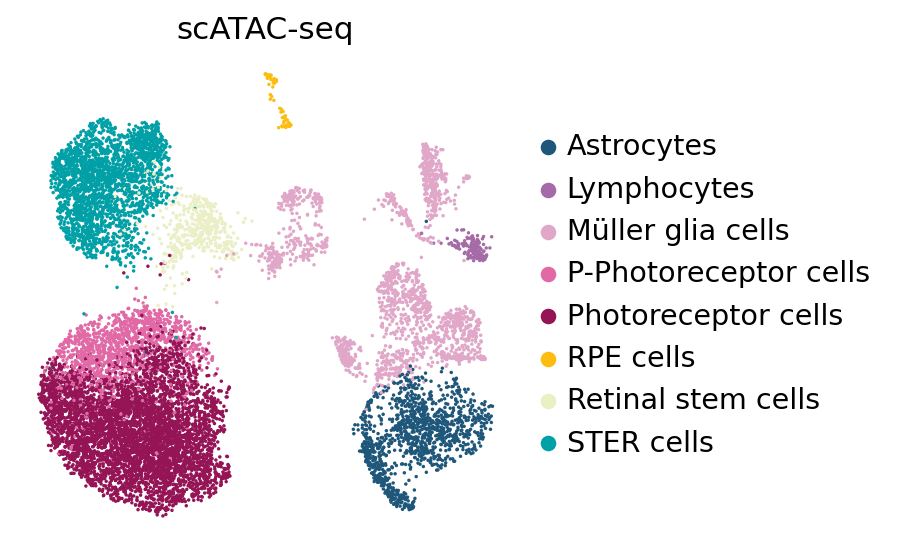

In [36]:
ax=sc.pl.embedding(
    black_atac,
    basis="X_umap",
    color='major_celltype_new',
    title='scATAC-seq',
    frameon=False,
    return_fig=True,
    show=False,
    ncols=3,
)
plt.savefig("result_1/momic_type_scatac.png",dpi=300,bbox_inches = 'tight')

In [37]:
black_rna=anndata.AnnData(rna[cell_new_obs].X,obs=atac[cell_new_obs].obs,var=rna[cell_new_obs].var)
black_rna.obs.index=cell_new_obs
black_rna.obsm['X_glue']=rna[cell_new_obs].obsm['X_glue']
black_rna.obsm['X_umap']=rna[cell_new_obs].obsm['X_umap']
black_rna.uns['major_celltype_colors']=atac[cell_new_obs].uns['major_celltype_colors']
black_rna.uns['major_celltype_new_colors']=atac[cell_new_obs].uns['major_celltype_new_colors']

In [38]:
black_rna.obs.index=black_rna.obs.index.astype('category')

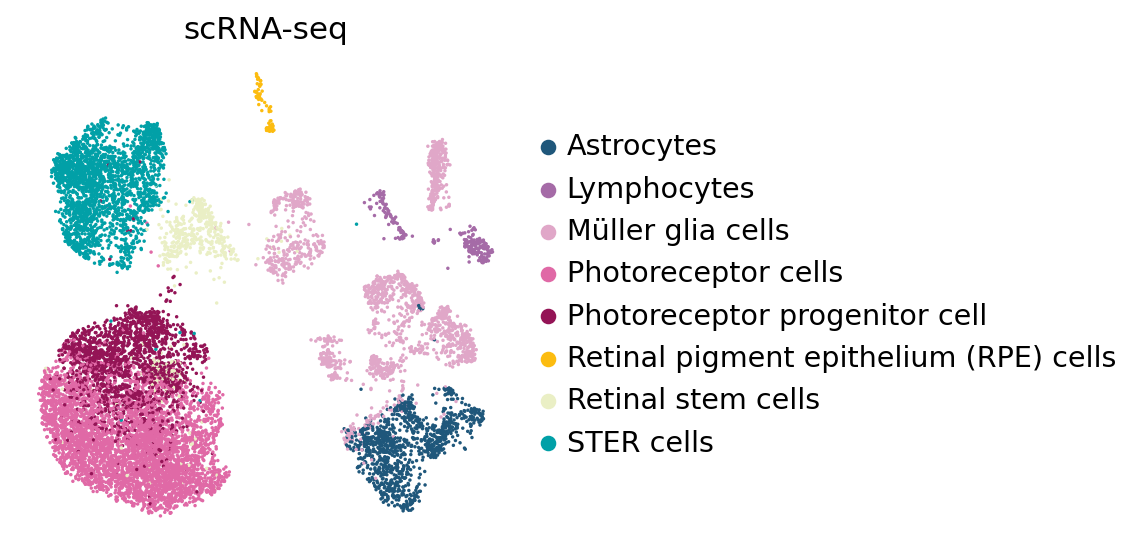

In [39]:
ax=sc.pl.embedding(
    black_rna,
    basis="X_umap",
    color='major_celltype',
    title='scRNA-seq',
    frameon=False,
    ncols=3,
    return_fig=True,
    show=False,
)
plt.savefig("result_1/momic_type_scrna.png",dpi=300,bbox_inches = 'tight')

In [40]:
t1 = time.time()
# 输入数据为umap数据
cell_coo = np.ascontiguousarray(black_rna.obsm["X_glue"])  
label = np.arange(1,len(black_rna.obs.index)+1)  
# 构建KD树
kd_tree = KDTree(cell_coo,label)
t2 = time.time()
print('创建树耗时：',t2-t1)

创建树耗时： 9.57364273071289


In [41]:
import time
import random
import numpy as np
import pandas as pd

# 设置rna的meta
black_rna.obs['label'] = np.arange(1,len(black_rna.obs.index)+1)
black_rna.obs['pseudobulk'] = ''
black_rna.obs
# 计时函数
t2 = time.time()
# 随机选择序列
list1 = range(1,len(black_rna.obs.index))
winners = random.sample(list1,200)
k=100
for i in winners:
    label, node_list = kd_tree.knn_algo(np.array(black_rna.obsm['X_glue'][i]),k)
    
    black_rna.obs.loc[black_rna.obs.index[i],'pseudobulk']=','.join([str(i[2]) for i in node_list])

t3 = time.time()
print('搜索200个细胞的前100个最近邻点耗时：',t3-t2)

搜索200个细胞的前100个最近邻点耗时： 30.289964199066162


In [42]:
rna_pseudobulk = black_rna.obs[black_rna.obs['pseudobulk']!='']
rna_pseudobulk.head()

,Tissue,Developmental_Stage,SRR,nb_features,log_nb_features,domain,balancing_weight,leiden,major_celltype,major_celltype_new,label,pseudobulk
106,Retina,Retinoblastoma_2years,SRR13633772,8068,3.906766,scATAC-seq,1.105408,13,Müller glia cells,Müller glia cells,107,"107,83,10365,110,495,10850,385,95,7546,621,747..."
204,Retina,Retinoblastoma_2years,SRR13633772,4192,3.622421,scATAC-seq,0.917406,14,Müller glia cells,Müller glia cells,205,"205,8987,14,2,9025,76,587,51,7466,9105,12216,1..."
239,Retina,Retinoblastoma_4months,SRR13633766,9671,3.985471,scATAC-seq,0.877238,0,Photoreceptor cells,Photoreceptor cells,240,"240,433,1936,625,1446,312,1432,726,3653,10459,..."
264,Retina,Retinoblastoma_2years,SRR13633772,3007,3.478133,scATAC-seq,1.105408,7,Müller glia cells,Müller glia cells,265,"265,45,300,169,10403,7552,12273,305,7498,9648,..."
340,Retina,Retinoblastoma_2years,SRR13633772,6211,3.793162,scATAC-seq,1.541924,7,Müller glia cells,Müller glia cells,341,"341,237,213,9053,227,817,170,10777,11447,247,6..."


In [43]:
import pandas as pd
gene2peak_res=pd.read_csv('linkage_4000.csv')
gene2peak_res.head()

,Unnamed: 0,rna,atac
0,0,LATS2,chr13_20988998_20989892
1,1,LATS2,chr13_21045951_21046953
2,2,ROM1,chr11_62608685_62609534
3,3,ROM1,chr11_62609699_62610184
4,4,NFKB1,chr4_102536484_102537399


In [44]:
gene2peak_res.shape,len(set(gene2peak_res['rna'])),len(set(gene2peak_res['atac']))

((661, 3), 408, 660)

In [45]:
rna1=list(set(gene2peak_res['rna']) & set(black_rna.var.index))
print(len(rna1))
atac1=list(set(gene2peak_res['atac']) & set(black_atac.var.index))
print(len(atac1))

408
660


In [46]:
black_rna.var_names_make_unique()
black_rna.obs_names_make_unique()

In [47]:
fi_rna=black_rna[:,rna1]
sc.pp.filter_genes(fi_rna, min_cells=30)
fi_rna

filtered out 18 genes that are detected in less than 30 cells


AnnData object with n_obs × n_vars = 12361 × 390
    obs: 'Tissue', 'Developmental_Stage', 'SRR', 'nb_features', 'log_nb_features', 'domain', 'balancing_weight', 'leiden', 'major_celltype', 'major_celltype_new', 'label', 'pseudobulk'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'hgnc_id', 'havana_gene', 'tag', 'dell'
    uns: 'major_celltype_colors', 'major_celltype_new_colors'
    obsm: 'X_glue', 'X_umap'

In [48]:
rna2=fi_rna.var.index.tolist()
rna2[0]

'PCDH10'

In [49]:
new_gene2peak=gene2peak_res.loc[(gene2peak_res['rna'].isin(rna2) & gene2peak_res['atac'].isin(atac1))]

In [50]:
black_rna[:,new_gene2peak['rna']],black_atac[:,new_gene2peak['atac']]

(View of AnnData object with n_obs × n_vars = 12361 × 641
     obs: 'Tissue', 'Developmental_Stage', 'SRR', 'nb_features', 'log_nb_features', 'domain', 'balancing_weight', 'leiden', 'major_celltype', 'major_celltype_new', 'label', 'pseudobulk'
     var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'hgnc_id', 'havana_gene', 'tag', 'dell'
     uns: 'major_celltype_colors', 'major_celltype_new_colors'
     obsm: 'X_glue', 'X_umap',
 View of AnnData object with n_obs × n_vars = 12361 × 641
     obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'SRR', 'Cancer', 'Tissue', '

In [51]:
black_rna.obs['label']=black_rna.obs['label'].astype('str')

In [52]:
pseudobulk_pd=pd.DataFrame(columns=new_gene2peak['rna'])
for i in range(len(rna_pseudobulk['pseudobulk'])):
    #找出最近的index
    pseu_index_list=black_rna.obs.loc[black_rna.obs['label'].isin(rna_pseudobulk['pseudobulk'].iloc[i].split(','))].index
    #计算均值
    pseudobulk_pd.loc[i]=np.array(black_rna[pseu_index_list,new_gene2peak['rna']].X.toarray()).mean(axis=0)

In [53]:
pseudobulk_pd.head()

rna,LATS2,LATS2,ROM1,ROM1,NFKB1,NFKB1,TNFRSF1A,TNFRSF1A,AURKA,IL6ST,...,LAMC3,KCNH4,LINC02055,LINC02055,CASP4,NOTCH2,CACNA2D3,DLGAP5,MDK,A2M
0,0.736920,0.736920,-0.088266,-0.088266,0.201044,0.201044,1.746409,1.746409,-0.264960,2.941404,...,1.127612,-0.058852,-0.002670,-0.002670,1.907982,0.972814,-0.046764,-0.247622,1.636193,-0.139607
1,0.590385,0.590385,-0.103075,-0.103075,-0.203309,-0.203309,0.490595,0.490595,-0.256912,1.168502,...,0.314867,-0.101169,-0.059686,-0.059686,0.556672,0.195389,-0.162346,-0.272162,-0.147546,-0.019543
2,-0.189758,-0.189758,-0.086970,-0.086970,0.054538,0.054538,-0.220210,-0.220210,-0.062431,0.051293,...,-0.028625,-0.005233,-0.059686,-0.059686,-0.186043,-0.218483,-0.151216,-0.213920,-0.459837,-0.133929
3,0.779888,0.779888,-0.141925,-0.141925,0.533950,0.533950,1.053502,1.053502,-0.255902,1.213492,...,-0.067862,-0.082183,-0.042896,-0.042896,0.468840,0.716844,0.106909,-0.278315,0.182384,-0.091593
4,0.688847,0.688847,-0.191349,-0.191349,0.638078,0.638078,1.125548,1.125548,-0.264960,1.768090,...,-0.080816,-0.082183,0.123235,0.123235,0.760761,0.658719,0.068473,-0.282288,0.020747,-0.023580


In [54]:
pseudobulk_pd_atac=pd.DataFrame(columns=new_gene2peak['atac'])
for i in range(len(rna_pseudobulk['pseudobulk'])):
    pseu_index_list=black_rna.obs.loc[black_rna.obs['label'].isin(rna_pseudobulk['pseudobulk'].iloc[i].split(','))].index
    pseudobulk_pd_atac.loc[i]=np.array(black_atac[pseu_index_list,new_gene2peak['atac']].X.toarray()).mean(axis=0)

In [55]:
pseudobulk_pd_atac.head()

atac,chr13_20988998_20989892,chr13_21045951_21046953,chr11_62608685_62609534,chr11_62609699_62610184,chr4_102536484_102537399,chr4_102551317_102552161,chr12_6332452_6333422,chr12_6338432_6339373,chr20_56387059_56387932,chr5_55976346_55977121,...,chr9_131084883_131085790,chr17_42177631_42178684,chr8_136045870_136046706,chr8_136057847_136058731,chr11_104950839_104951686,chr1_119967953_119968758,chr3_54486805_54487612,chr14_55187254_55188205,chr11_46388583_46389560,chr12_9114141_9115023
0,0.00,0.00,0.00,0.00,0.02,0.10,0.0,0.00,0.00,0.00,...,0.08,0.00,0.02,0.00,0.52,0.02,0.02,0.00,0.02,0.02
1,0.00,0.00,0.00,0.00,0.01,0.08,0.0,0.02,0.00,0.00,...,0.01,0.00,0.00,0.00,0.46,0.04,0.00,0.00,0.00,0.04
2,0.00,0.00,0.03,0.18,0.13,0.02,0.0,0.00,0.01,0.02,...,0.00,0.04,0.04,0.02,0.02,0.02,0.09,0.02,0.02,0.00
3,0.02,0.00,0.00,0.06,0.04,0.12,0.0,0.02,0.02,0.02,...,0.06,0.00,0.00,0.00,0.18,0.04,0.02,0.00,0.04,0.00
4,0.00,0.02,0.00,0.01,0.02,0.08,0.0,0.00,0.00,0.02,...,0.06,0.00,0.02,0.00,0.34,0.02,0.00,0.02,0.02,0.00


In [56]:
pseudobulk_pd.shape,pseudobulk_pd_atac.shape

((200, 641), (200, 641))

In [57]:
pseudobulk_pd.columns=['linkage'+str(i) for i in range(len(pseudobulk_pd.columns))]
pseudobulk_pd

,linkage0,linkage1,linkage2,linkage3,linkage4,linkage5,linkage6,linkage7,linkage8,linkage9,...,linkage631,linkage632,linkage633,linkage634,linkage635,linkage636,linkage637,linkage638,linkage639,linkage640
0,0.736920,0.736920,-0.088266,-0.088266,0.201044,0.201044,1.746409,1.746409,-0.264960,2.941404,...,1.127612,-0.058852,-0.002670,-0.002670,1.907982,0.972814,-0.046764,-0.247622,1.636193,-0.139607
1,0.590385,0.590385,-0.103075,-0.103075,-0.203309,-0.203309,0.490595,0.490595,-0.256912,1.168502,...,0.314867,-0.101169,-0.059686,-0.059686,0.556672,0.195389,-0.162346,-0.272162,-0.147546,-0.019543
2,-0.189758,-0.189758,-0.086970,-0.086970,0.054538,0.054538,-0.220210,-0.220210,-0.062431,0.051293,...,-0.028625,-0.005233,-0.059686,-0.059686,-0.186043,-0.218483,-0.151216,-0.213920,-0.459837,-0.133929
3,0.779888,0.779888,-0.141925,-0.141925,0.533950,0.533950,1.053502,1.053502,-0.255902,1.213492,...,-0.067862,-0.082183,-0.042896,-0.042896,0.468840,0.716844,0.106909,-0.278315,0.182384,-0.091593
4,0.688847,0.688847,-0.191349,-0.191349,0.638078,0.638078,1.125548,1.125548,-0.264960,1.768090,...,-0.080816,-0.082183,0.123235,0.123235,0.760761,0.658719,0.068473,-0.282288,0.020747,-0.023580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.194525,-0.194525,0.144459,0.144459,-0.270552,-0.270552,-0.215493,-0.215493,-0.085649,-0.050052,...,0.006260,0.101934,-0.059686,-0.059686,-0.186043,-0.208090,-0.131954,0.021531,-0.465869,-0.131369
196,0.336457,0.336457,-0.149922,-0.149922,0.034280,0.034280,0.881292,0.881292,-0.170569,1.642440,...,-0.098488,-0.101169,0.031772,0.031772,0.437897,0.524480,-0.002285,-0.211311,-0.102072,-0.103089
197,0.364821,0.364821,-0.140016,-0.140016,0.087691,0.087691,0.821359,0.821359,-0.065603,1.706816,...,-0.098488,-0.101169,-0.018146,-0.018146,0.353008,0.417022,-0.006346,-0.211311,-0.091340,-0.058672
198,-0.194525,-0.194525,0.056631,0.056631,-0.236566,-0.236566,-0.220210,-0.220210,0.485576,-0.244673,...,-0.098488,0.186447,-0.059686,-0.059686,-0.186043,-0.222435,-0.162346,0.455280,-0.471144,-0.064211


In [58]:
pseudobulk_pd_atac.columns=['linkage'+str(i) for i in range(len(pseudobulk_pd_atac.columns))]
pseudobulk_pd_atac

,linkage0,linkage1,linkage2,linkage3,linkage4,linkage5,linkage6,linkage7,linkage8,linkage9,...,linkage631,linkage632,linkage633,linkage634,linkage635,linkage636,linkage637,linkage638,linkage639,linkage640
0,0.00,0.00,0.00,0.00,0.02,0.10,0.00,0.00,0.00,0.00,...,0.08,0.00,0.02,0.00,0.52,0.02,0.02,0.00,0.02,0.02
1,0.00,0.00,0.00,0.00,0.01,0.08,0.00,0.02,0.00,0.00,...,0.01,0.00,0.00,0.00,0.46,0.04,0.00,0.00,0.00,0.04
2,0.00,0.00,0.03,0.18,0.13,0.02,0.00,0.00,0.01,0.02,...,0.00,0.04,0.04,0.02,0.02,0.02,0.09,0.02,0.02,0.00
3,0.02,0.00,0.00,0.06,0.04,0.12,0.00,0.02,0.02,0.02,...,0.06,0.00,0.00,0.00,0.18,0.04,0.02,0.00,0.04,0.00
4,0.00,0.02,0.00,0.01,0.02,0.08,0.00,0.00,0.00,0.02,...,0.06,0.00,0.02,0.00,0.34,0.02,0.00,0.02,0.02,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.00,0.00,0.02,0.19,0.04,0.04,0.01,0.00,0.00,0.04,...,0.00,0.00,0.02,0.00,0.02,0.00,0.00,0.04,0.00,0.00
196,0.00,0.00,0.00,0.03,0.00,0.06,0.00,0.04,0.00,0.00,...,0.05,0.00,0.04,0.00,0.40,0.02,0.04,0.00,0.04,0.00
197,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.04,0.00,0.02,...,0.05,0.00,0.02,0.00,0.40,0.04,0.04,0.02,0.04,0.00
198,0.00,0.00,0.04,0.08,0.03,0.02,0.02,0.00,0.00,0.02,...,0.04,0.00,0.00,0.02,0.00,0.00,0.02,0.04,0.00,0.00


In [59]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(pseudobulk_pd)
from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()#实例化
#scaler.fit(X_scaled) #生成了均值&方差
#result_rna = scaler.transform(X_scaled) #通过transform接口导出标准化结果
result_rna=X_scaled
result_rna=pd.DataFrame(result_rna,index=pseudobulk_pd.index,columns=pseudobulk_pd.columns)

In [60]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(pseudobulk_pd_atac)
from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()#实例化
#scaler.fit(X_scaled) #生成了均值&方差
#result_rna = scaler.transform(X_scaled) #通过transform接口导出标准化结果
result_atac=X_scaled
result_atac=pd.DataFrame(result_atac,index=pseudobulk_pd_atac.index,columns=pseudobulk_pd_atac.columns)

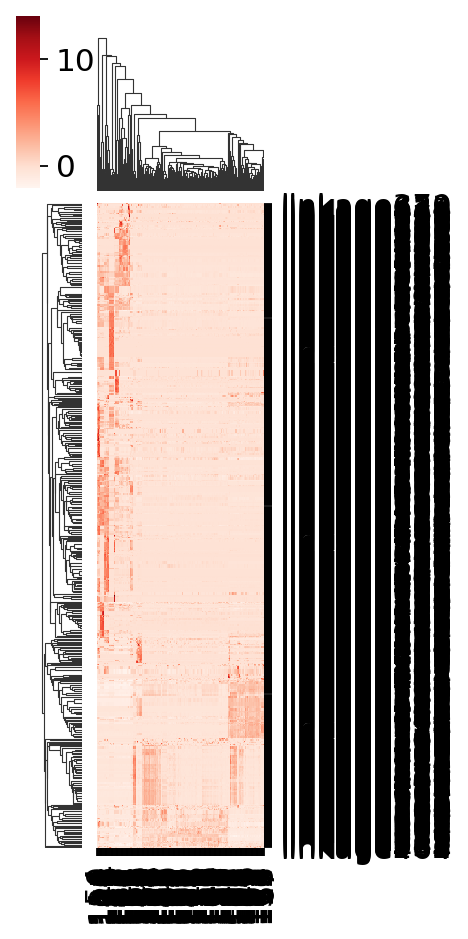

In [98]:
import seaborn as sns
a1=sns.clustermap(result_rna.T,figsize=(3,6),cmap='Reds',yticklabels=True,xticklabels=True,)

In [99]:
ylabel=[i.get_text() for i in a1.ax_heatmap.get_yticklabels()]
xlabel=[int(i.get_text()) for i in a1.ax_heatmap.get_xticklabels()]

In [100]:
meta_color=dict(zip(atac.obs['major_celltype_new'].cat.categories,atac.uns['major_celltype_new_colors']))
meta_color

{'Astrocytes': '#1f577b',
 'Lymphocytes': '#a56ba7',
 'Müller glia cells': '#e0a7c8',
 'P-Photoreceptor cells': '#e069a6',
 'Photoreceptor cells': '#941456',
 'RPE cells': '#fcbc10',
 'Retinal stem cells': '#eaefc5',
 'STER cells': '#01a0a7'}

<AxesSubplot:title={'center':'scATAC-seq'}, xlabel='X_umap1', ylabel='X_umap2'>

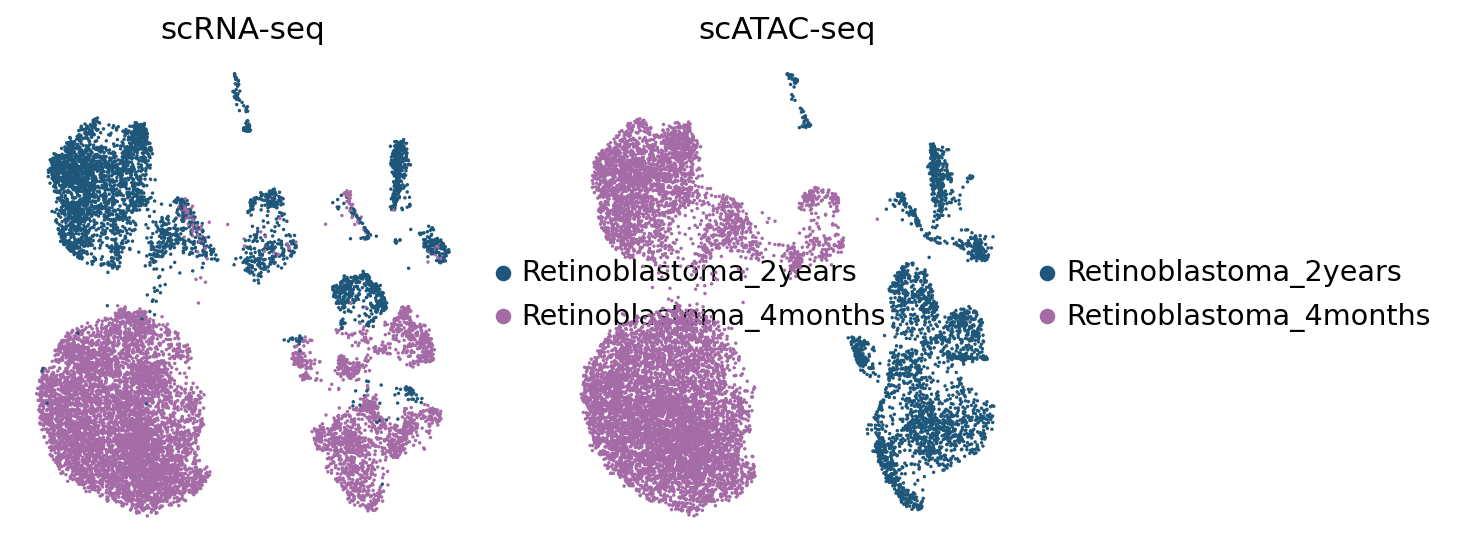

In [101]:
fig, axes = plt.subplots(1,2,figsize=(8,4))

sc.pl.embedding(
    rna,
    basis="X_umap",
    color=['Developmental_Stage'],
    title='scRNA-seq',
    frameon=False,
    ncols=1,
    #save='_figure1_celltype.png',
    #return_fig=True,
    #wspace=0.5,
    show=False,
    ax=axes[0],
    palette=sc_color[11:],
)

sc.pl.embedding(
    atac,
    basis="X_umap",
    color=['Developmental_Stage'],
    title='scATAC-seq',
    frameon=False,
    ncols=1,
    #save='_figure1_celltype.png',
    #return_fig=True,
    #wspace=0.5,
    show=False,
    ax=axes[1],
    palette=sc_color[11:],
)


In [102]:
Type_color=dict(zip(atac.obs['Developmental_Stage'].cat.categories,atac.uns['Developmental_Stage_colors']))
Type_color

{'Retinoblastoma_2years': '#1f577b', 'Retinoblastoma_4months': '#a56ba7'}

In [103]:
type_color=Type_color

type_color_rna=meta_color
type_color_atac=meta_color


In [104]:
atac_pseudobulk=black_atac.obs.loc[rna_pseudobulk.index]
atac_pseudobulk.head()

,initial_size_spliced,initial_size_unspliced,initial_size,SRR,Cancer,Tissue,Developmental_Stage,sample,Type,n_genes,...,total_counts,total_counts_mt,pct_counts_mt,domain,leiden,SRR1,balancing_weight,n_counts,major_celltype,major_celltype_new
106,8255,6861,8255.0,SRR13633761,RB,Retinoblastoma,Retinoblastoma_2years,RB-SRR13633761,paracarcinoma,5145,...,18599.0,914.0,4.914243,scRNA-seq,14,SRR13633761,0.953635,244.786606,Müller glia cells,Müller glia cells
204,11416,3910,11416.0,SRR13633761,RB,Retinoblastoma,Retinoblastoma_2years,RB-SRR13633761,paracarcinoma,4989,...,19068.0,477.0,2.501573,scRNA-seq,13,SRR13633761,0.889263,181.758179,Müller glia cells,Müller glia cells
239,15445,16916,15445.0,SRR13633760,RB,Retinoblastoma,Retinoblastoma_4months,RB-SRR13633760,carcinoma,8386,...,39127.0,1100.0,2.811358,scRNA-seq,0,SRR13633760,0.914462,353.887299,Photoreceptor cells,Photoreceptor cells
264,15637,4973,15637.0,SRR13633759,RB,Retinoblastoma,Retinoblastoma_4months,RB-SRR13633759,paracarcinoma,5419,...,26026.0,1327.0,5.098747,scRNA-seq,12,SRR13633759,1.298644,63.676739,Müller glia cells,Müller glia cells
340,13216,5217,13216.0,SRR13633759,RB,Retinoblastoma,Retinoblastoma_4months,RB-SRR13633759,paracarcinoma,4441,...,23097.0,969.0,4.195350,scRNA-seq,12,SRR13633759,1.298644,13.423809,Müller glia cells,Müller glia cells


In [105]:
color_map=pd.DataFrame(index=range(200))
color_map['scATAC']=rna_pseudobulk.loc[:,'major_celltype_new'].map(type_color_atac).values
#color_map['scATAC'].index=range(200)
color_map['scRNA']=atac_pseudobulk.loc[:,'major_celltype_new'].map(type_color_rna).values
color_map['Type']=atac_pseudobulk.loc[:,'Developmental_Stage'].map(type_color).values
#color_map['scRNA'].index=range(200)
color_map

,scATAC,scRNA,Type
0,#e0a7c8,#e0a7c8,#1f577b
1,#e0a7c8,#e0a7c8,#1f577b
2,#941456,#941456,#a56ba7
3,#e0a7c8,#e0a7c8,#a56ba7
4,#e0a7c8,#e0a7c8,#a56ba7
...,...,...,...
195,#941456,#941456,#a56ba7
196,#e0a7c8,#e0a7c8,#a56ba7
197,#e0a7c8,#e0a7c8,#a56ba7
198,#e069a6,#941456,#a56ba7


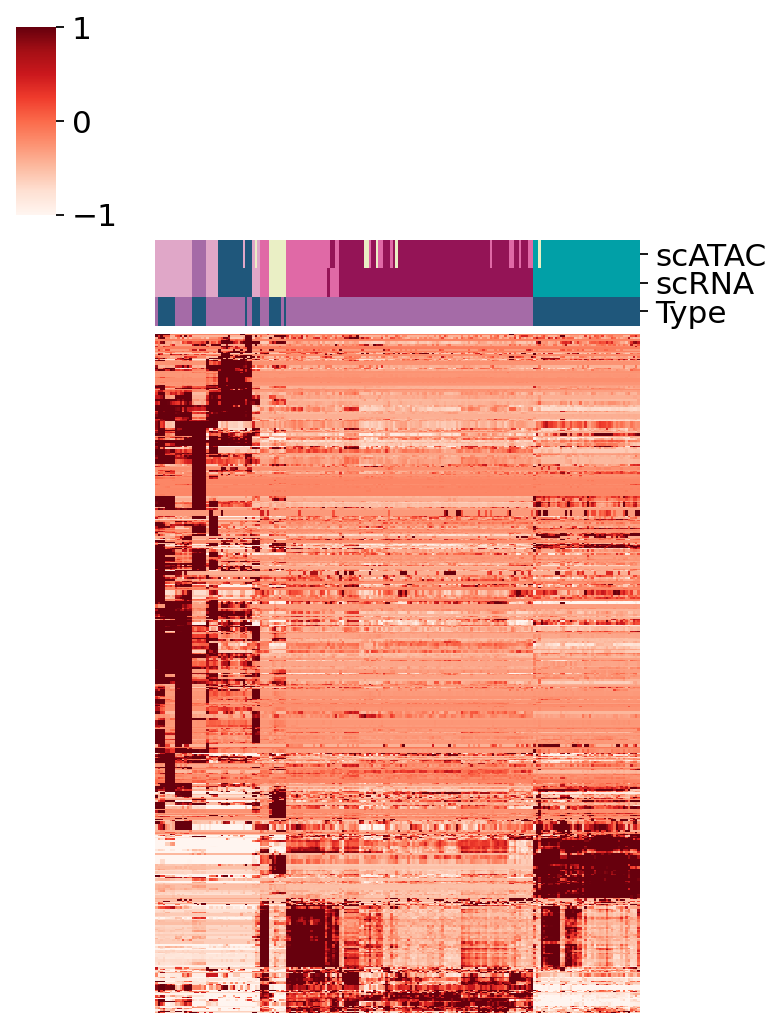

In [106]:
sns.clustermap(result_rna.loc[xlabel,ylabel].T,cmap='Reds',
                   standard_scale=None,row_cluster=False, vmax=1,vmin=-1,
               xticklabels=False,yticklabels=False,
               col_cluster=False,col_colors=color_map,figsize=(5,6.5))
#plt.savefig("results/figure2_heatmap_rna.png",dpi=300,bbox_inches = 'tight')

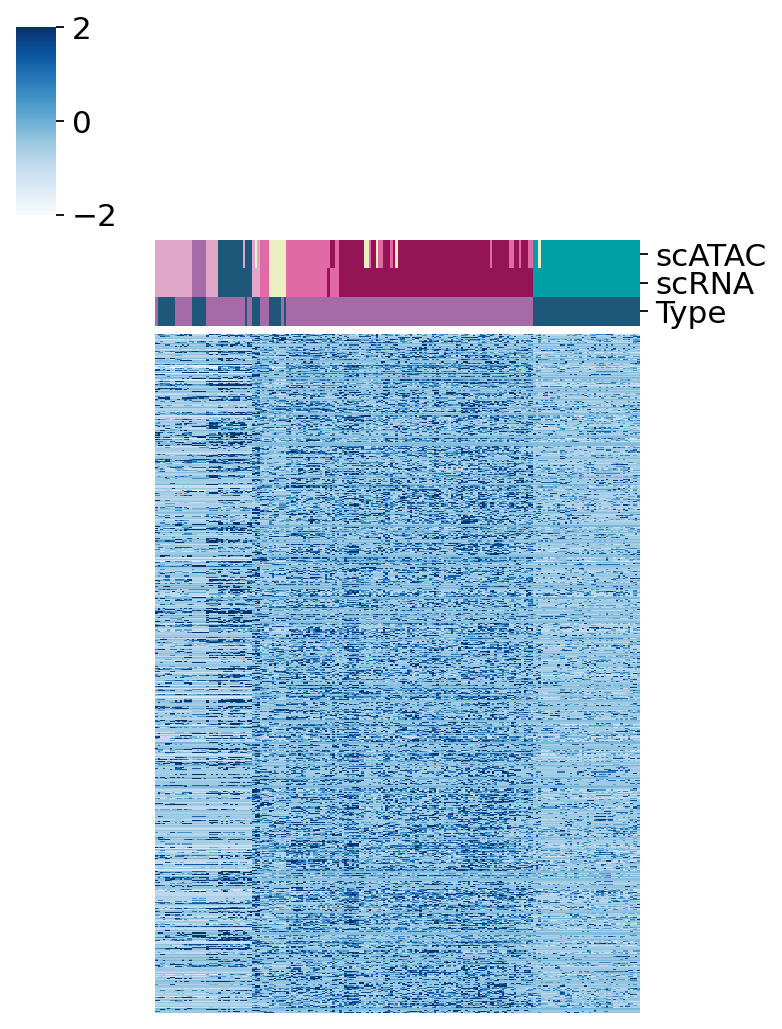

In [107]:
sns.clustermap(result_atac.loc[xlabel,ylabel].T,cmap='Blues',
                   standard_scale=None,row_cluster=False, vmax=2,vmin=-2,
               xticklabels=False,yticklabels=False,
               col_cluster=False,col_colors=color_map,figsize=(5,6.5))
#plt.savefig("results/figure2_heatmap_atac.png",dpi=300,bbox_inches = 'tight')

In [108]:
#cal cor
from scipy import stats
gene2peak_cor=[]
for i in new_gene2peak.index:
    cor1=stats.spearmanr(atac[atac_pseudobulk.index,new_gene2peak.loc[i,'atac']].X.toarray().T[0],
            rna[rna_pseudobulk.index,new_gene2peak.loc[i,'rna']].X.toarray().T[0])[0]
    gene2peak_cor.append(cor1)
#value counts
ttt=new_gene2peak.value_counts('rna')
gene2peak_num=ttt.loc[new_gene2peak['rna']].tolist()

new_gene2peak['cor']=gene2peak_cor
new_gene2peak['num']=gene2peak_num

In [109]:
reb=[]
new_gene2peak=new_gene2peak.sort_values('cor',ascending=False)
new_gene2peak1=pd.DataFrame(columns=new_gene2peak.columns)
for i in new_gene2peak.index:
    t1=new_gene2peak.loc[i,'rna']
    if t1 not in reb:
        reb.append(t1)
        new_gene2peak1.loc[i]=new_gene2peak.loc[i]
    else:
        continue
      

In [120]:
new_gene2peak1=new_gene2peak1.dropna()
new_gene2peak1.sort_values('cor')

,Unnamed: 0,rna,atac,cor,num
19,19,JUN,chr1_58781839_58782795,-0.141491,1
300,300,TACSTD2,chr1_58577563_58578478,-0.136766,1
222,222,SMC4,chr3_160434531_160435441,-0.132314,1
33,33,MLLT11,chr1_151064409_151065450,-0.099923,4
85,85,INSM2,chr14_35534128_35534971,-0.080607,1
...,...,...,...,...,...
264,264,KRT15,chr17_41512050_41513143,0.274656,1
653,653,CASP4,chr11_104950839_104951686,0.287995,1
406,406,LINC01094,chr4_78647952_78648819,0.348129,1
97,97,WFDC21P,chr17_60088183_60089031,0.701757,1


In [121]:
new_gene2peak.loc[new_gene2peak['rna']=='WFDC21P']

,Unnamed: 0,rna,atac,cor,num
97,97,WFDC21P,chr17_60088183_60089031,0.701757,1


In [111]:
new_gene2peak1['cor']=new_gene2peak1['cor'].astype(np.float64)
new_gene2peak1['num']=new_gene2peak1['num'].astype(int)

In [123]:
act=sc.read('data/act_anno_new.h5ad')
act

AnnData object with n_obs × n_vars = 21194 × 59454
    obs: 'Tissue', 'Developmental_Stage', 'SRR', 'nb_features', 'log_nb_features', 'domain', 'balancing_weight', 'leiden', 'major_celltype', 'major_celltype_new', 'umap_density_major_celltype_new', 'CD3D'
    uns: 'Developmental_Stage_colors', 'SRR_colors', '__scglue__', 'leiden', 'leiden_colors', 'major_celltype_colors', 'major_celltype_new_colors', 'neighbors', 'umap', 'umap_density_major_celltype_new_params'
    obsm: 'X_glue', 'X_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [128]:
act=adata_rename(act,res_pair,omic_name='omic_2')

In [131]:
#sc.pp.normalize_total(act)
sc.pp.scale(act, max_value=10)
sc.pp.highly_variable_genes(act, min_mean=0.0125, max_mean=3, min_disp=0.5)
act = act[:, act.var.highly_variable]
act

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


View of AnnData object with n_obs × n_vars = 12361 × 8333
    obs: 'Tissue', 'Developmental_Stage', 'SRR', 'nb_features', 'log_nb_features', 'domain', 'balancing_weight', 'leiden', 'major_celltype', 'major_celltype_new', 'umap_density_major_celltype_new', 'CD3D'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Developmental_Stage_colors', 'SRR_colors', '__scglue__', 'leiden', 'leiden_colors', 'major_celltype_colors', 'major_celltype_new_colors', 'neighbors', 'umap', 'umap_density_major_celltype_new_params', 'hvg'
    obsm: 'X_glue', 'X_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [132]:
rna1=sc.read('data/rna_anno_new.h5ad')
rna1

AnnData object with n_obs × n_vars = 20037 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'SRR', 'Cancer', 'Tissue', 'Developmental_Stage', 'sample', 'Type', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'SRR1', 'balancing_weight', 'n_counts', 'major_celltype', 'major_celltype_new'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'hgnc_id', 'havana_gene', 'tag', 'dell', 'dispersions', 'dispersions_norm'
    uns: 'Cancer_colors', 'Developmental_Stage_color

In [133]:
ret_gene=list(set(act.var.index) & set(rna1.var.index))
len(ret_gene)

427

In [134]:
rna1=adata_rename(rna1,res_pair,omic_name='omic_1')

In [143]:
act.obs.index=[str(i) for i in act.obs.index]
rna1.obs.index=[str(i) for i in rna1.obs.index]

In [175]:
from scipy import stats
gene2peak_cor=[]
res_gene2act=pd.DataFrame()
for i in ret_gene:
    cor1=stats.spearmanr(act[atac_pseudobulk.index,i].X.toarray().T[0],
            rna1[rna_pseudobulk.index,i].X.toarray().T[0])[0]
    gene2peak_cor.append(cor1)
res_gene2act['gene']=ret_gene
res_gene2act['cor']=gene2peak_cor
res_gene2act

,gene,cor
0,WNK2,-0.014422
1,NUTF2,0.013662
2,PTGES3,-0.083631
3,ABCA17P,0.001322
4,CDO1,-0.101005
...,...,...
422,UQCRH,0.083174
423,DENND4A,0.100344
424,LRCH1,0.011251
425,ZSCAN32,-0.027189


In [146]:
res_gene2act.sort_values('cor').tail(10)

,gene,cor
313,ZMYND10,0.183752
120,LINC01970,0.191894
135,CUL1,0.203325
367,SMC5,0.204514
399,PANK2,0.210801
128,AKAP1,0.251003
72,ALX3,NaN
199,GAPLINC,NaN
396,TFAP2B,NaN
411,CASP1,NaN


In [164]:
rna.var.loc[ret_gene,['n_cells_by_counts']].max()

n_cells_by_counts    19998
dtype: int64

In [178]:
res_gene2act['prop']=rna.var.loc[ret_gene,['n_cells_by_counts']].values.reshape(-1)/20037
res_gene2act['abs_cor']=abs(res_gene2act['cor'])
res_gene2act['sig']='normal'
res_gene2act.loc[res_gene2act['abs_cor']>0.2,'sig']='sig'

In [ ]:
ret_gene

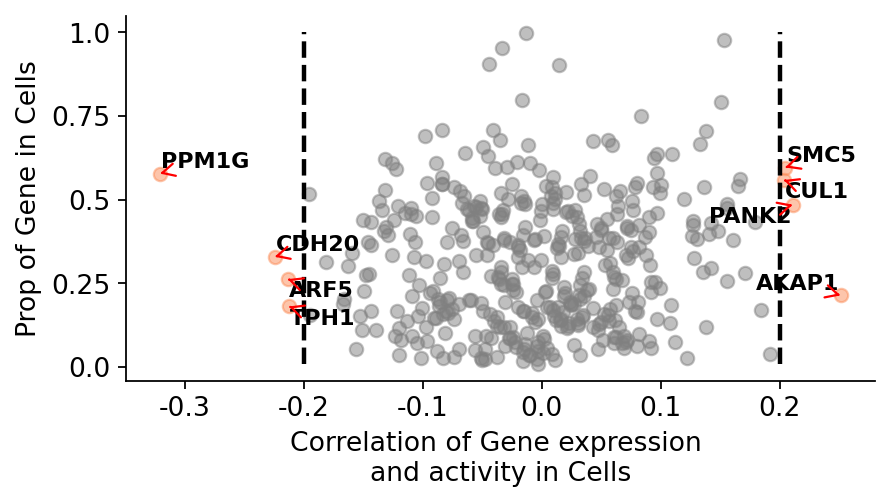

In [237]:
fig, ax = plt.subplots(figsize=(6,3))
#首先绘制正常基因
ax.scatter(x=res_gene2act.loc[res_gene2act['sig']=='normal']['cor'].values,
           y=res_gene2act.loc[res_gene2act['sig']=='normal']['prop'],
           color='grey',#颜色
           alpha=.5,#透明度
           )
#接着绘制上调基因
ax.scatter(x=res_gene2act.loc[res_gene2act['sig']=='sig']['cor'].values,
           y=res_gene2act.loc[res_gene2act['sig']=='sig']['prop'],
           color='#FC8D59',#选择色卡第15个颜色
           alpha=.5,#透明度
           )
ax.plot([0.2,0.2],
        [res_gene2act['prop'].min(),1],
        linewidth=2, 
        linestyle="--",
        color='black')
ax.plot([-0.2,-0.2],
        [res_gene2act['prop'].min(),1],
        linewidth=2, 
        linestyle="--",
        color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
from adjustText import adjust_text

hub_gene=res_gene2act.loc[res_gene2act['abs_cor']>0.2].index.tolist()
texts=[ax.text(res_gene2act.loc[i,'cor'], 
               res_gene2act.loc[i,'prop'],
               res_gene2act.loc[i,'gene'],
               fontdict={'size':10,'weight':'bold'}
               ) for i in hub_gene[:20]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)
plt.grid(False)

ax.set_xticks(ax.get_xticks()[1:-1],#获取x坐标轴内容
              [round(i,2) for i in ax.get_xticks()[1:-1]],#更新x坐标轴内容
              fontsize=12,
              )


ax.set_yticks(ax.get_yticks()[1:-1],#获取x坐标轴内容
              [round(i,2) for i in ax.get_yticks()[1:-1]],#更新x坐标轴内容
              fontsize=12,
              )

ax.set_ylabel('Prop of Gene in Cells',fontsize=12)
ax.set_xlabel('Correlation of Gene expression \nand activity in Cells',fontsize=12)
fig.savefig('result_2/prop_cor_genes.png',dpi=300,bbox_inches='tight')

In [233]:
sc.tl.rank_genes_groups(act, 'major_celltype_new', method='t-test',n_genes=100)
rna.uns['log1p']['base']=None
sc.tl.rank_genes_groups(rna, 'major_celltype_new', method='t-test',n_genes=100)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


In [234]:
target_dict_all={}
for ad,name in zip([rna,act],['RNA','ACT']):
    celltype=[(i, 'O') for i in ad.uns['rank_genes_groups']['names'].dtype.names]
    target_dict={}
    target_pd=pd.DataFrame()
    for i in range(len(celltype)):
        cellmarker=[]
        for k in range(100):
            #rank_genes_groups
            cellmarker.append(ad.uns['rank_genes_groups']['names'][k][i])
        #print(cellmarker[0])
        target_pd[celltype[i][0]]=cellmarker
        #ret_target=list(set(cellmarker) & set(rnk_gene))
        target_dict[celltype[i][0]]=cellmarker

    target_dict.keys(),len(cellmarker)
    target_dict_all[name]=target_dict

In [235]:
ret_target_dict={}
for i in range(len(celltype)):
    ret_target_dict[celltype[i][0]]=list(set(target_dict_all['RNA'][celltype[i][0]]) &  set(ret_gene))
ret_target_dict

{'Astrocytes': ['ZFP36L1', 'SPINT2', 'RND3', 'CLDN4', 'RPS12'],
 'Lymphocytes': ['CALM1', 'RPS15', 'RPS12', 'TTR'],
 'Müller glia cells': ['FOSB', 'RPS12', 'ZFP36L1'],
 'P-Photoreceptor cells': ['ANLN', 'PEX5L'],
 'Photoreceptor cells': ['AGBL4', 'PEX5L'],
 'RPE cells': ['TTR', 'APP'],
 'Retinal stem cells': [],
 'STER cells': ['PDS5B', 'TPH1', 'CDH20']}

In [236]:
res_gene2act.loc[res_gene2act['gene'].isin(['PDS5B', 'TPH1', 'CDH20'])]

,gene,cor,prop,abs_cor,sig
27,CDH20,-0.224496,0.329291,0.224496,sig
95,TPH1,-0.212523,0.180766,0.212523,sig
236,PDS5B,-0.122217,0.590458,0.122217,normal


In [229]:
#这里纯人眼识别，其实可以开发一个算法的
cluster2annotation = {
     '0': 'Photoreceptor cells',
     '1': 'Photoreceptor cells',
     '2': 'Photoreceptor progenitor cell',#Germ-cell(Oid)
     '3': 'Retinal stem cells',#Germ-cell(Oid)
     '4': 'Astrocytes',
     '5': 'STER cells',
     '6': 'STER cells',
     '7': 'Müller glia cells',
     '8': 'Photoreceptor cells',
     '9': 'STER cells',
     '10': 'Photoreceptor progenitor cell',#Germ-cell(Oid)
     '11': 'Müller glia cells',
     '12': 'Retinal stem cells',
     '13': 'Müller glia cells',
     '14': 'Müller glia cells',
     '15': 'Astrocytes',#Germ
     '16': 'Lymphocytes',#plasma
     '17': 'Photoreceptor progenitor cell',#plasma
     '18': 'Müller glia cells',
     '19': 'Müller glia cells',
     '20': 'Retinal pigment epithelium (RPE) cells',#Germ-cell(Oid)



}
act.obs['major_celltype'] = atac.obs['leiden'].map(cluster2annotation).astype('category')

In [230]:
act.obs['major_celltype_new']=act.obs['major_celltype']
act.obs['major_celltype_new']=act.obs['major_celltype_new'].astype('str')
act.obs.loc[act.obs['major_celltype']=='Retinal pigment epithelium (RPE) cells','major_celltype_new']='RPE cells'
act.obs.loc[act.obs['major_celltype']=='Retinal progenitor cells (RPCs)','major_celltype_new']='RPCs'
act.obs.loc[act.obs['major_celltype']=='Photoreceptor progenitor cell','major_celltype_new']='P-Photoreceptor cells'
act.obs['major_celltype_new']=act.obs['major_celltype_new'].astype('category')